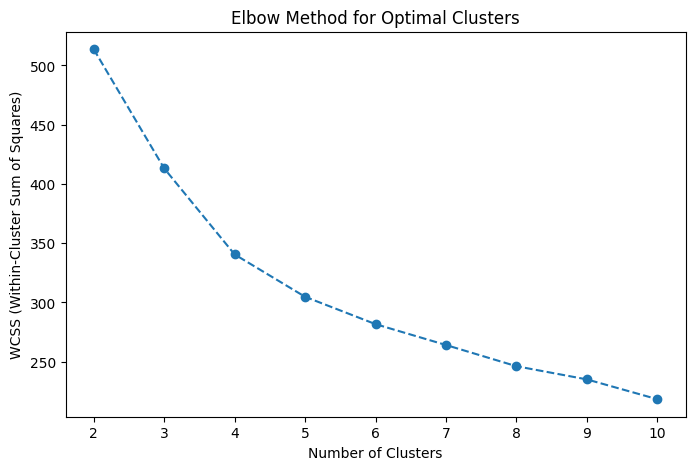

Davies-Bouldin Index: 1.298
Silhouette Score: 0.242


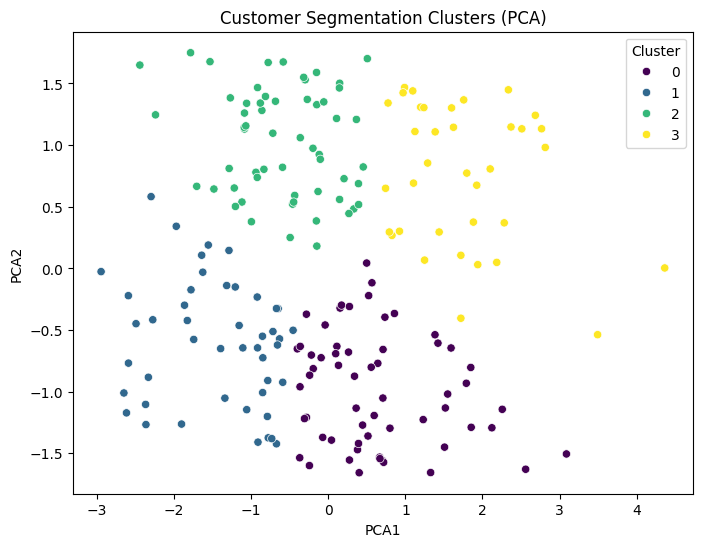

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load data
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

# Feature Engineering
customers['SignupDuration'] = (pd.Timestamp.now() - pd.to_datetime(customers['SignupDate'])).dt.days
customer_data = customers.merge(
    transactions.groupby('CustomerID').agg(
        TotalTransactions=('TransactionID', 'count'),
        TotalSpent=('TotalValue', 'sum')
    ), on='CustomerID', how='left'
).fillna(0)  # Fill missing transaction data

# Encode and Scale Data
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), ['Region']),
    ('num', StandardScaler(), ['SignupDuration', 'TotalTransactions', 'TotalSpent'])
])
X = preprocessor.fit_transform(customer_data)

# Determine Optimal Clusters using Elbow Method
wcss = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

# Fit KMeans with optimal k (let's assume 4 from the elbow method)
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
customer_data['Cluster'] = clusters

# Clustering Metrics
db_index = davies_bouldin_score(X, clusters)
silhouette = silhouette_score(X, clusters)

print(f"Davies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {silhouette:.3f}")

# Visualization using PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
customer_data['PCA1'], customer_data['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title("Customer Segmentation Clusters (PCA)")
plt.show()

# Save Clustered Data
customer_data.to_csv("Clustered_Customers.csv", index=False)
